In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score 

In [3]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import fasttext

In [4]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, GlobalMaxPool1D, Flatten
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model

In [5]:
seed = 7
np.random.seed(seed)

## Explore the data-set

In [6]:
df = pd.read_csv('question_answer_pairs.csv')

In [7]:
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Alessandro_Volta,Was Alessandro Volta a professor of chemistry?,Alessandro Volta was not a professor of chemis...,easy,easy,data/set4/a10
1,Alessandro_Volta,Was Alessandro Volta a professor of chemistry?,No,easy,hard,data/set4/a10
2,Alessandro_Volta,Did Alessandro Volta invent the remotely opera...,Alessandro Volta did invent the remotely opera...,easy,easy,data/set4/a10
3,Alessandro_Volta,Did Alessandro Volta invent the remotely opera...,Yes,easy,easy,data/set4/a10
4,Alessandro_Volta,Was Alessandro Volta taught in public schools?,Volta was taught in public schools.,easy,easy,data/set4/a10


In [8]:
df.shape

(1458, 6)

In [9]:
df = df.drop_duplicates(subset='Question')\
    .reset_index(drop=True)
    
df.shape

(832, 6)

In [10]:
df['ArticleTitle'].value_counts()

Trumpet                        27
San_Francisco                  27
Alessandro_Volta               27
Ant                            26
Jakarta                        26
Malay_language                 24
Drum                           23
Korean_language                23
Charles-Augustin_de_Coulomb    20
Violin                         19
Giant_Panda                    18
Kuala_Lumpur                   18
Guitar                         18
Amedeo_Avogadro                18
Xylophone                      18
Nikola_Tesla                   18
James_Watt                     18
Michael_Faraday                18
Berlin                         18
Chinese_language               18
Montreal                       18
Turkish_language               18
Vietnamese_language            18
Piano                          17
Nairobi                        17
Saint_Petersburg               17
Isaac_Newton                   17
Arabic_language                17
Flute                          17
Octopus       

In [11]:
unique_titles = df['ArticleTitle'].unique()
unique_titles.shape

(56,)

## Create lables

In [12]:
label_map = {key:value for value,key in enumerate(unique_titles)}

In [13]:
label_map

{'Alessandro_Volta': 0,
 'Amedeo_Avogadro': 1,
 'Ant': 2,
 'Antwerp': 3,
 'Arabic_language': 4,
 'Berlin': 5,
 'Blaise_Pascal': 6,
 'Butterfly': 7,
 'Cello': 8,
 'Charles-Augustin_de_Coulomb': 9,
 'Chinese_language': 10,
 'Cougar': 11,
 'Cymbal': 12,
 'Dragonfly': 13,
 'Drum': 14,
 'Eel': 15,
 'Finnish_language': 16,
 'Flute': 17,
 'Giant_Panda': 18,
 'Guitar': 19,
 'Henri_Becquerel': 20,
 'Isaac_Newton': 21,
 'Jackson_Pollock': 22,
 'Jakarta': 23,
 'James_Watt': 24,
 'Koala': 25,
 'Korean_language': 26,
 'Kuala_Lumpur': 27,
 'Leonardo_da_Vinci': 28,
 'Lobster': 29,
 'Lyre': 30,
 'Malay_language': 31,
 'Melbourne': 32,
 'Michael_Faraday': 33,
 'Michelangelo': 34,
 'Montreal': 35,
 'Nairobi': 36,
 'Nikola_Tesla': 37,
 'Norman_Rockwell': 38,
 'Octopus': 39,
 'Pablo_Picasso': 40,
 'Piano': 41,
 'Pierre-Auguste_Renoir': 42,
 'Portuguese_language': 43,
 'Saint_Petersburg': 44,
 'San_Francisco': 45,
 'Swahili_language': 46,
 'Swedish_language': 47,
 'Taipei': 48,
 'Trumpet': 49,
 'Turkish_la

In [14]:
df['label'] = df['ArticleTitle'].map(label_map)

In [15]:
df.sample(5)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,label
790,Violin,What is a violin called informally?,Fiddle,medium,medium,data/set2/a2,53
689,San_Francisco,In what year did the Spanish establish a fort ...,"In 1776, the Spanish established a fort at the...",NaN,medium,data/set3/a8,45
134,Butterfly,What is the outer layer of the cuticle made of?,The outer layer of the cuticle is made of of a...,medium,easy,data/set1/a6,7
351,Jakarta,Who created Monas Park,General Herman Willem Deandels,medium,medium,data/set3/a5,23
510,Michelangelo,Wasn't Michelangelo abstemious?,Michelangelo was abstemious.,NaN,medium,data/set6/a2,34


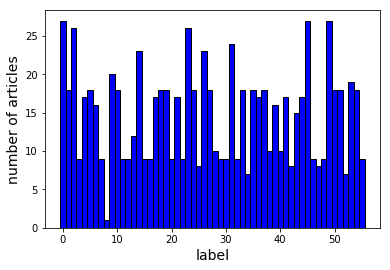

In [16]:
plt.hist(df['label'], bins=np.linspace(-0.5,55.5,57), color='blue', ec='black')
plt.xlabel('label', fontsize=14)
plt.ylabel('number of articles', fontsize=14)
plt.xticks([0, 10, 20, 30, 40, 50])
plt.show()

## Splitting into Train / Val / Test Sets

In [17]:
x_train, x_val, y_train, y_val = train_test_split(df['Question'], 
                                                  df['label'], 
                                                  test_size=0.2)
                                                  #stratify=df['label'])

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x_val,
                                                y_val, 
                                                test_size=0.5)
                                                #stratify=y_val)

## Clean text

In [19]:
#stops = set(stopwords.words("english"))
#stemmer = SnowballStemmer('english')

def clean_text(text):
    text = str(text) #to string
    text = re.sub('<.*?>', '',text) # remove html
    text = text.lower() # make lowercase
    text = text.replace('á', 'a').replace('à', 'a')
    text = text.replace('é', 'e').replace('è', 'e')
    text = text.replace('í', 'i').replace('ì', 'i')
    text = text.replace('ó', 'o').replace('ò', 'o')
    text = text.replace('ú', 'u').replace('ù', 'u')
    text = re.sub('http\S+', ' ', text) # remove urls
    text = re.sub('[^a-z]+', ' ', text) # remove non-characters
    text = re.sub(' +', ' ', text) # remove multiple spaces
    #text = [w for w in text.split() if not w in stops] # remove stop words
    #text = [stemmer.stem(word) for word in text] # stemming
    #text = " ".join(text).encode('utf-8')
    return text

In [20]:
clean_text('<p>Installing<p> the game was a   '+ 
            'struggle (because of... 1 2 3   ??'+ 
            'https://translate.google.co.uk/ some reasons')

'installing the game was a struggle because of some reasons'

In [21]:
x_train = x_train.apply(clean_text)
x_val = x_val.apply(clean_text)
x_test = x_test.apply(clean_text)

## Vectorization with fasttext

In [22]:
fasttext_model = fasttext\
    .load_model('../fasttext-en.bin')

In [23]:
vector = np.array(fasttext_model['hello'])
vector.shape

(100,)

In [24]:
embedding_dim = 100
max_sequence_length = 50

In [25]:
def create_sequences(x):
    sequences = np.zeros((len(x), max_sequence_length, embedding_dim), dtype=np.float32)
    for i,text in enumerate(x.values):
        words = text.split()
        seq_length = len(words)
        if len(words) > max_sequence_length:
            seq_length = max_sequence_length
        if words:
            sequences[i][:seq_length] = [fasttext_model[w] for w in words][:seq_length]
    return sequences

In [26]:
train_sequences = create_sequences(x_train)
train_sequences.shape

(665, 50, 100)

In [27]:
test_sequences = create_sequences(x_test)
test_sequences.shape

(84, 50, 100)

In [28]:
val_sequences = create_sequences(x_val)
val_sequences.shape

(83, 50, 100)

## The model

In [29]:
C = len(unique_titles)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(max_sequence_length, embedding_dim,)))
model.add(GlobalMaxPool1D(name='vectorizer'))
model.add(Dropout(0.1))
model.add(Dense(C, activation='softmax'))

In [30]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50, 100)           10100     
_________________________________________________________________
vectorizer (GlobalMaxPooling (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                5656      
Total params: 15,756
Trainable params: 15,756
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [32]:
callbacks = [EarlyStopping(monitor='val_loss', 
                           patience=4),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

In [33]:
%%time
history = model.fit(
    train_sequences,
    keras.utils.to_categorical(y_train,C),
    batch_size=10,
    epochs=50,
    callbacks=callbacks,
    validation_data=(val_sequences,keras.utils.to_categorical(y_val,C))
)

Train on 665 samples, validate on 83 samples
Epoch 1/50
665/665 [==============================] - 1s 2ms/step - loss: 3.9439 - acc: 0.0722 - val_loss: 3.7411 - val_acc: 0.1325
Epoch 2/50
665/665 [==============================] - 0s 737us/step - loss: 3.4654 - acc: 0.2120 - val_loss: 3.3764 - val_acc: 0.2410
Epoch 3/50
665/665 [==============================] - 0s 710us/step - loss: 3.0019 - acc: 0.3534 - val_loss: 2.9121 - val_acc: 0.3976
Epoch 4/50
665/665 [==============================] - 0s 617us/step - loss: 2.5111 - acc: 0.5083 - val_loss: 2.4424 - val_acc: 0.5301
Epoch 5/50
665/665 [==============================] - 0s 718us/step - loss: 2.0668 - acc: 0.6000 - val_loss: 2.0654 - val_acc: 0.6265
Epoch 6/50
665/665 [==============================] - 1s 769us/step - loss: 1.6743 - acc: 0.7008 - val_loss: 1.7462 - val_acc: 0.7229
Epoch 7/50
665/665 [==============================] - 0s 686us/step - loss: 1.3903 - acc: 0.7880 - val_loss: 1.4578 - val_acc: 0.7831
Epoch 8/50
665/665 

In [34]:
history.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

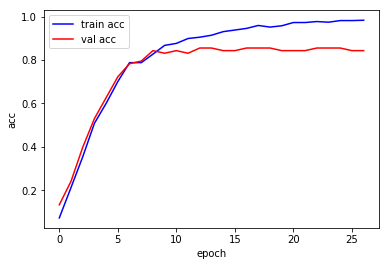

In [35]:
plt.plot(history.epoch,history.history['acc'], c='b', label='train acc')
plt.plot(history.epoch,history.history['val_acc'], c='r', label='val acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Evaluate the model

In [36]:
model.metrics_names

['loss', 'acc']

In [37]:
accuracy = model.evaluate(test_sequences,
                          keras.utils.to_categorical(y_test,C), 
                          verbose=0)[1]

accuracy

0.8214285714285714

## Save the model

In [38]:
model.save('model.h5')
#model2 = load_model('model.h5')
#model2.predict_classes(test_sequences)

# Find similar texts

## Vectorize train and test sequences

In [39]:
vectorizer = Model(model.input, model.get_layer('vectorizer').output)

In [40]:
# vectorize all the train sequences
train_vectors = vectorizer.predict(train_sequences)
train_vectors = normalize(train_vectors, axis=1, norm='l2')
train_vectors.shape

(665, 100)

In [41]:
# vectorize all the test sequences
test_vectors = vectorizer.predict(test_sequences)
test_vectors = normalize(test_vectors, axis=1, norm='l2')
test_vectors.shape

(84, 100)

## Calculate cosine similarity

In [42]:
cosine_similarity_matrix = np.dot(test_vectors, train_vectors.transpose())
cosine_similarity_matrix.shape

(84, 665)

In [43]:
best_match_index = np.argmax(cosine_similarity_matrix, axis=1)
best_match_index.shape

(84,)

In [44]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [45]:
y_predicted = y_train[best_match_index].reset_index(drop=True)
y_predicted.shape

(84,)

In [46]:
y_test.shape

(84,)

In [47]:
accuracy_score(y_test,y_predicted)

0.7857142857142857

## Match text

In [48]:
text = 'Does the octopus have a hard beak?'

In [49]:
def create_sequence_from_text(text):
    matrix = np.zeros((1, max_sequence_length, embedding_dim))
    words = text.split()
    seq_length = len(words)
    if len(words) > max_sequence_length:
        seq_length = max_sequence_length
    if words:
        matrix[0][:seq_length] = [fasttext_model[w] for w in words][:seq_length]
    return matrix

In [50]:
text_sequence = create_sequence_from_text(text)
text_sequence.shape

(1, 50, 100)

In [51]:
text_vector = vectorizer.predict(text_sequence)
text_vector = normalize(text_vector, axis=1, norm='l2')
text_vector.shape

(1, 100)

In [52]:
cosine_similarity = np.dot(text_vector, test_vectors.transpose())#cosine similarity
cosine_similarity.shape

(1, 84)

In [53]:
best_match_index = np.argmax(cosine_similarity, axis=1)
best_match_index.shape

(1,)

In [54]:
pd.set_option('display.max_colwidth', -1)

In [55]:
best_match = x_test[best_match_index]
best_match

5    has an octopus a hard beak with its mouth at the center point of the arms 
Name: Question, dtype: object